# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [3]:
# посмотрим на числовые признаки, у которые содержат бОльший разброс данных
churn_data_cut_int = churn_data[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']]
churn_data_cut_int.describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,199992.480000


In [4]:
# посмотрим на строковые признаки
churn_data_cut_obj = churn_data[['Geography', 'Gender']]
churn_data_cut_obj.groupby(['Geography'], as_index=False)['Gender'].count()

,Geography,Gender
0,France,5014
1,Germany,2509
2,Spain,2477


In [5]:
# посмотрим на сбалансированность классов
round(churn_data['Exited'].value_counts(normalize=True),2)

0    0.8
1    0.2
Name: Exited, dtype: float64

<AxesSubplot: xlabel='Exited', ylabel='count'>

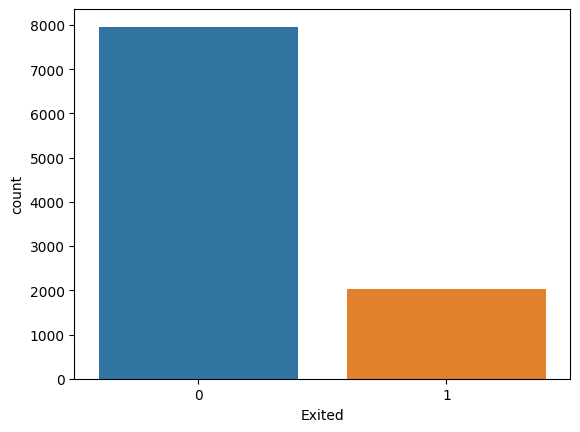

In [6]:
# на графике
sns.countplot(data=churn_data, x='Exited')

Для построения графиков объединим признаки, имеющие большое количество данных, в группы.

In [7]:
# функция перевода числового признака 'CreditScore' в категориальный
def get_credit_score_rate(credit_sc:int) -> str:
    """ Функция присвоения кредитной категории по кредитному рейтингу

    Args:
        credit_sc (int): числовое значение кредитного рейтинга

    Returns:
        str: категориальное значение кредитного рейтинга
    """

    if credit_sc in range (350, 501): return "низкий"
    if credit_sc in range (501, 601): return "умеренно низкий"
    if credit_sc in range (601, 661): return "умеренный"
    if credit_sc in range (661, 781): return "умеренно высокий"
    if credit_sc in range (781, 851): return "высокий"

In [8]:
# функция перевода числового признака 'Age' в категориальный
def get_age_cat(age:int) -> str:
    """ Функция присвоения возрастной категории по возрасту

    Args:
        age (int): числовое значение возраста

    Returns:
        str: категориальное значение возраста
    """
    if age in range (18, 21) : return "18_20"
    if age in range (21, 26) : return "21_25"
    if age in range (26, 31) : return "26_30"
    if age in range (31, 36) : return "31_35"
    if age in range (36, 41) : return "36_40"
    if age in range (41, 46) : return "41_45"
    if age in range (46, 51) : return "46_50"
    if age in range (51, 56) : return "51_55"
    if age in range (56, 61) : return "56_60"
    if age in range (61, 66) : return "61_65"
    if age in range (66, 71) : return "66_70"
    if age in range (71, 76) : return "71_75"
    if age in range (76, 81) : return "76_80"
    if age in range (81, 86) : return "81_85"
    if age in range (86, 93): return "86_93"

In [9]:
# функция перевода числового признака 'Balance' в категориальный
def balance_cat(balance:int) -> str:
    """ Функция присвоения степени использования счета категории по балансу

    Args:
        balance (int): числовое значение баланса

    Returns:
        str: категориальное значение баланса
    """
    if balance in range (0, 101) : return "пассивный"
    if balance in range (101, 1001) : return "умеренно пассивный"
    if balance in range (1001, 10001) : return "умеренно активный"
    if balance in range (10001, 50001) : return "активный"
    if balance in range (50001, 251000) : return "очень активный"

In [10]:
# функция перевода числового признака 'EstimatedSalary' в категориальный
def EstimatedSalary_cat(estimatedsalary:int) -> str:
    """ Функция присвоения категории з/п по з/п

    Args:
        balance (int): числовое значение з/п

    Returns:
        str: категориальное значение з/п
    """
    if estimatedsalary in range (0, 201) : return "не работает"
    if estimatedsalary in range (201, 2001) : return "низкооплачиваемый"
    if estimatedsalary in range (2001, 10001) : return "средний"
    if estimatedsalary in range (10001, 50001) : return "высокий"
    if estimatedsalary in range (50001, 200000) : return "топ"

In [11]:
# формирование нового признака 'CreditScoreCat'
churn_data['CreditScoreCat'] = churn_data['CreditScore'].apply(get_credit_score_rate)

In [12]:
# формирование нового признака 'AgeCat'
churn_data['AgeCat'] = churn_data['Age'].apply(get_age_cat)

In [13]:
# формирование нового признака 'Balance_Cat'
churn_data['Balance_Cat'] = churn_data['Balance'].apply(balance_cat)

In [14]:
# формирование нового признака 'EstimatedSalary_Cat'
churn_data['EstimatedSalary_Cat'] = churn_data['EstimatedSalary'].apply(EstimatedSalary_cat)

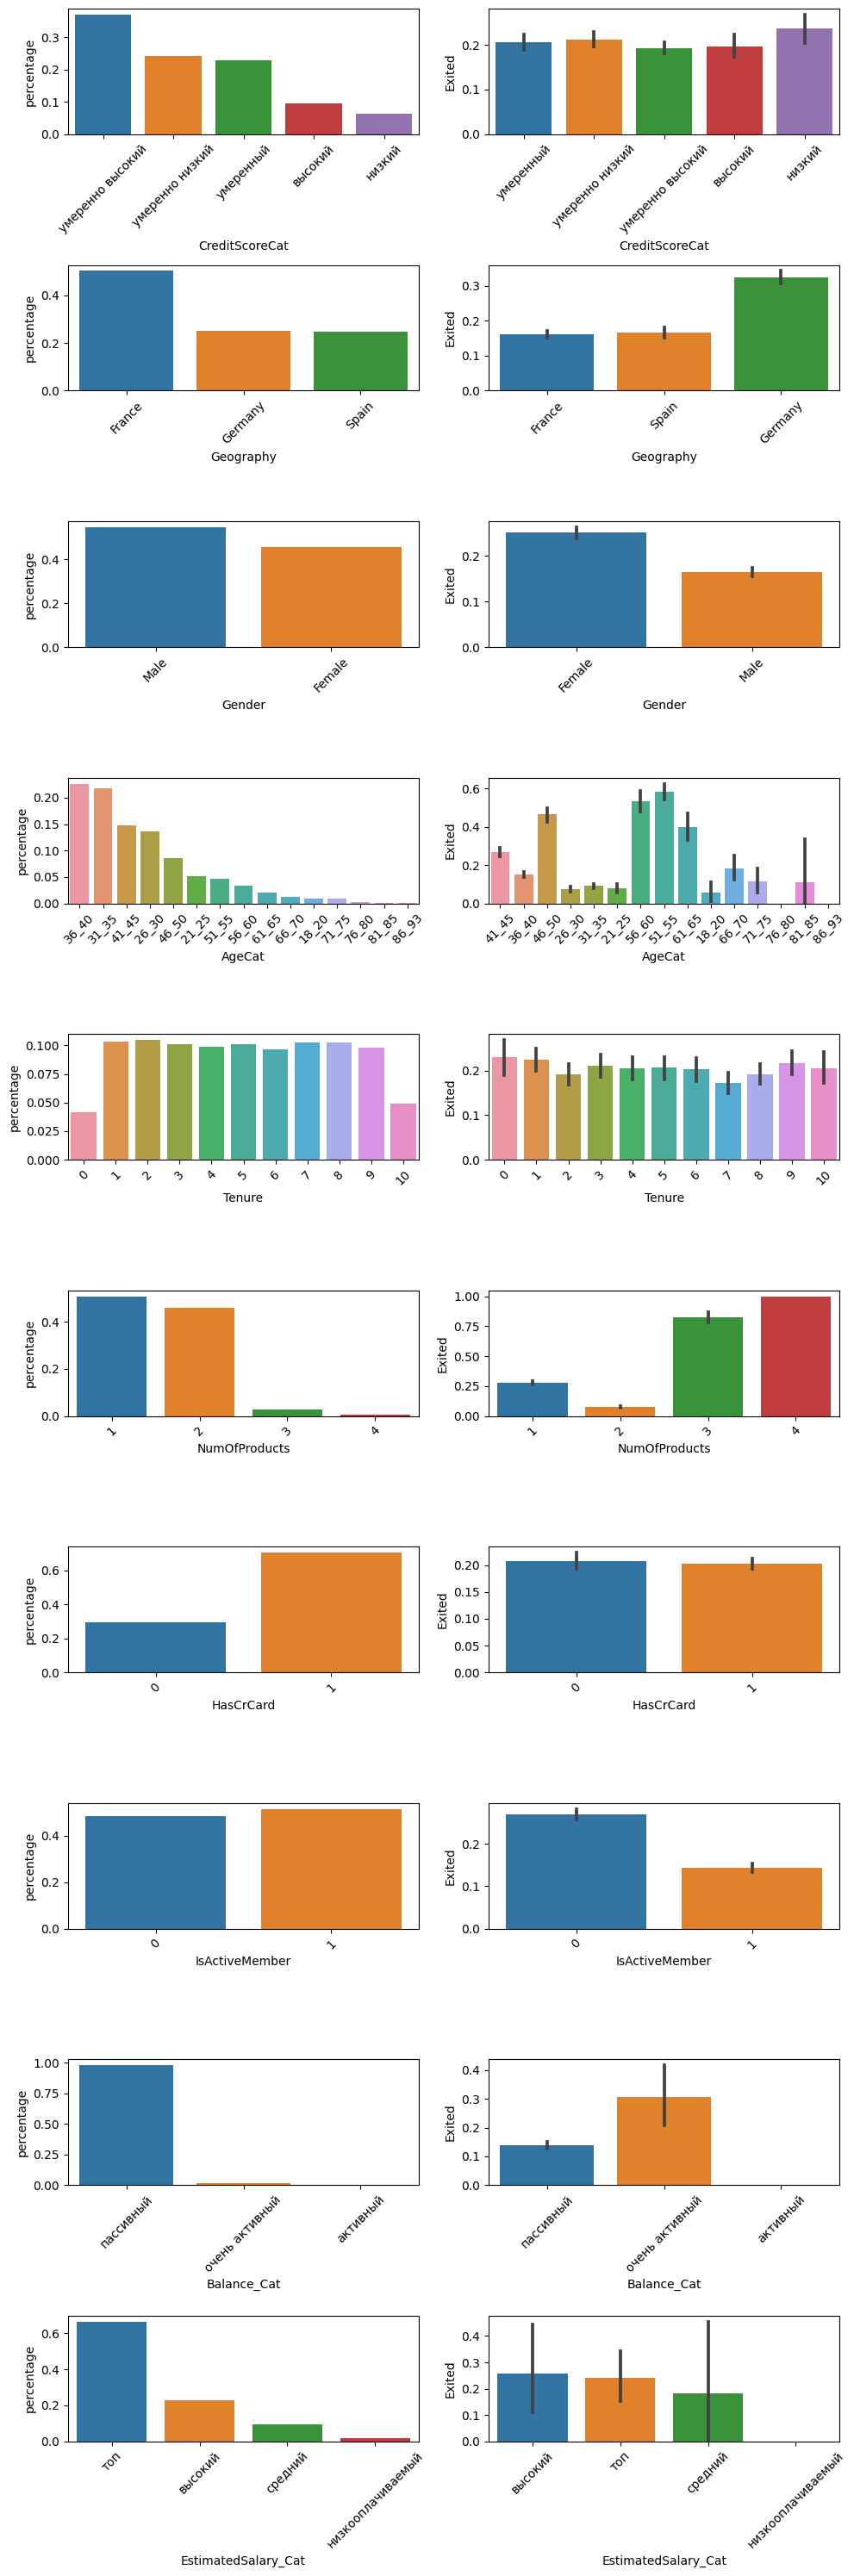

In [15]:
features = ['CreditScoreCat', 'Geography', 'Gender', 'AgeCat', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Balance_Cat', 'EstimatedSalary_Cat']

n = len(features)                                       # число признаков
fig, axes = plt.subplots(n, 2, figsize=(10, 30))        # фигура + n*2 координатных плоскостей

# цикл для всех признаков из списка
for i, feature in enumerate(features):
    # формируем сводную таблицу
    count_data = (churn_data[feature].value_counts(normalize=True)
        .sort_values(ascending=False)
        .rename('percentage')
        .reset_index()
    )
    # строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_barplot = sns.barplot(
        data=count_data, 
        x='index', 
        y='percentage', 
        ax=axes[i][0]
    )
    # поворот меток на оси абсцисс на 45 градусов
    count_barplot.xaxis.set_tick_params(rotation=45)
    # задаём название оси абсцисс
    count_barplot.set(xlabel=feature)

    # строим столбчатую диаграмму доли людей ушедших из банка в зависимости от признака
    mean_barplot = sns.barplot(data=churn_data, x=feature, y='Exited', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout();                                     # выравнивание графиков


В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [16]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 18)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента. 

In [17]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname', 'CreditScoreCat', 'AgeCat', 'Balance_Cat', 'EstimatedSalary_Cat'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [18]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [19]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [20]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / (churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / (churn_data['Age'])

# перекодируем единичный текстовый категориальный признак 'Gender' в бинарный столбец (1 — 'Male', 0 — 'Female')
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [21]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [22]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [23]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [24]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64



Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

<span style="color:green">Разброс данных довольно большой - стандартизация не подходит. Предположим, что в наших данных нет неверно предоставленных данных, т.к речь о банке, а значит большие и маленькие значения обоснованы и данные не содержат выбросов. Значит воспользуемся нормализатором MinMaxScaler</span>

In [25]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


<span style="color:green">Задание размытое. Определимся, что в первую очередь у нас все же ограничены ресурсы. Тогда в первую очередь необходимо улучшить метрику precision, так как она позволяет минимизировать количество ложноположительных срабатываний модели. Ложноположительное срабатывание означает, что модель предсказала отток клиента, но на самом деле клиент не собирается уходить из банка. Если мы сможем улучшить точность модели, то мы сможем снизить количество звонков, которые будут сделаны клиентам, которые не собираются уходить, и тем самым сэкономить ресурсы колл-центра. Однако, при этом мы должны также следить за метрикой recall, чтобы не пропустить клиентов, которые действительно собираются уходить из банка</span>

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

<span style="color:green">Из курса мы знаем, что F1-мера является гармоническим средним между precision и recall, и она хорошо подходит для задач, где классы несбалансированы. Видимо, от студента ждут ответа, что необходимо ориентироваться на эту метрику. Конечно ее учитывать тоже будем, тем более, что metrics.classification_report() показывает все метрики. Однако в данной задаче мы имеем ограниченные ресурсы на сохранение клиентов, поэтому нам важно минимизировать количество звонков, которые мы делаем клиентам. Precision позволяет нам оценить, как много из тех клиентов, которым мы предлагаем специальные предложения, действительно склонны к оттоку. Таким образом, мы можем минимизировать количество звонков, которые мы делаем, и при этом сохранить как можно больше клиентов. Поэтому в данной задаче мы будем пытаться улучшить метрику precision</span>

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [26]:
# создаём объект класса логистической регрессии с SGD
log_reg_l1 = linear_model.LogisticRegression(
    penalty='l1',
    C=5,
    max_iter=1000,
    solver='saga', 
    random_state=42,
)

# обучаем модель — ищем параметры по методу SGD
log_reg_l1.fit(X_train_scaled, y_train)

LogisticRegression(C=5, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')

In [27]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_l1.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_l1.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1271
           1       0.63      0.44      0.52       610

    accuracy                           0.73      1881
   macro avg       0.70      0.66      0.67      1881
weighted avg       0.72      0.73      0.72      1881

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       424
           1       0.60      0.42      0.50       204

    accuracy                           0.72       628
   macro avg       0.68      0.64      0.65       628
weighted avg       0.71      0.72      0.71       628



In [28]:
# создаём объект класса логистической регрессии с SGD
log_reg_l2 = linear_model.LogisticRegression(
    penalty='l2',
    C=5,
    max_iter=1000,
    solver='sag', 
    random_state=42,
)

# обучаем модель — ищем параметры по методу SGD
log_reg_l2.fit(X_train_scaled, y_train)

LogisticRegression(C=5, max_iter=1000, random_state=42, solver='sag')

In [29]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg_l2.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg_l2.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1271
           1       0.63      0.42      0.51       610

    accuracy                           0.73      1881
   macro avg       0.69      0.65      0.66      1881
weighted avg       0.72      0.73      0.72      1881

              precision    recall  f1-score   support

           0       0.75      0.87      0.81       424
           1       0.60      0.41      0.49       204

    accuracy                           0.72       628
   macro avg       0.68      0.64      0.65       628
weighted avg       0.71      0.72      0.70       628



<span style="color:green">Протестировала различные параметры С и penalty. Для наглядности оставила выходные данные для L1 и L2 с одинаковыми параметрами. Результаты регуляризации L1 немного лучше. 
<span style="color:green">С чем это может быть связано: 

<span style="color:green">1. L1-регуляризация склонна к созданию разреженных моделей, то есть моделей, в которых большинство весов равны нулю. Это может быть полезно, если входные данные содержат много ненужных признаков, которые не влияют на результат. В таком случае L1-регуляризация может помочь убрать эти признаки из модели, что может улучшить ее качество.

<span style="color:green">2. L2-регуляризация, с другой стороны, склонна к созданию моделей с более равномерными весами, что может быть полезно, если все признаки важны для результата. Однако, если входные данные содержат много шума, то L2-регуляризация может ухудшить качество модели, так как она будет учитывать этот шум.

<span style="color:green">3. Возможно, что входные данные имеют особенности, которые лучше подходят для L1-регуляризации, чем для L2-регуляризации. Например, если входные данные содержат много коррелирующих признаков, то L1-регуляризация может помочь выбрать наиболее важные из них, тогда как L2-регуляризация может сохранить все признаки.

<span style="color:green">4. Наконец, результаты могут зависеть от конкретной задачи и данных, поэтому может потребоваться провести более тщательное исследование, чтобы понять, какая регуляризация лучше подходит для данной задачи.

<span style="color:green">Получила результат F1 при L1 - больше или равно 0.5. В данном случае, модель имеет высокую точность и полноту на классе 0 (оставшиеся), а на классе 1 (ушедшие) - ниже. Метрики для класса 0 выше, чем для класса 1. Это может говорить о том, что модель лучше предсказывает оставшихся клиентов, чем их уход. А это не соответствуе нашей задаче.</span>

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [30]:
# создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False);
poly.fit(X_train_scaled);

# генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)

# генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)

# выводим результирующие размерности таблиц
print(f'Train data shape: {X_train_scaled_poly.shape}')
print(f'Test data shape: {X_test_scaled_poly.shape}')

# создаём объект класса логистической регрессии с SGD
lr_poly = linear_model.LogisticRegression(
    penalty='l1',
    C=5,
    max_iter=1000,
    solver='saga', 
    random_state=42,
);

# обучаем модель с полиномиальными коэффициентами — ищем параметры по методу SGD
lr_poly.fit(X_train_scaled_poly, y_train);

# делаем предсказание на тренировочной выборке
y_train_pred_lr_poly = lr_poly.predict(X_train_scaled_poly)

# делаем предсказание на тестовой выборке
y_test_pred_lr_poly = lr_poly.predict(X_test_scaled_poly)

## вывод отчета о метриках классификации
# ТРЕНИРОВОЧНАЯ ВЫБОРКА
print(f'Train data "F1 score": {metrics.f1_score(y_train, y_train_pred_lr_poly):.2f}')
print(metrics.classification_report(y_train, y_train_pred_lr_poly))

# ТЕСТОВАЯ ВЫБОРКА
print(f'Test data "F1 score": {metrics.f1_score(y_test, y_test_pred_lr_poly):.2f}')
print(metrics.classification_report(y_test, y_test_pred_lr_poly))

Train data shape: (1881, 454)
Test data shape: (628, 454)
Train data "F1 score": 0.71
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1271
           1       0.78      0.65      0.71       610

    accuracy                           0.83      1881
   macro avg       0.81      0.78      0.79      1881
weighted avg       0.82      0.83      0.82      1881

Test data "F1 score": 0.67
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       424
           1       0.72      0.63      0.67       204

    accuracy                           0.80       628
   macro avg       0.77      0.75      0.76       628
weighted avg       0.79      0.80      0.79       628



/home/tatiana/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


<span style="color:green">Нам удалось значительно улучшить показатели. Возможные причины: 

<span style="color:green">Модель на полиномиальных признаках может показывать лучшие результаты, чем модель на линейных признаках, поскольку она может учитывать нелинейные зависимости между признаками и целевой переменной. 

<span style="color:green">В линейной регрессии предполагается, что зависимость между признаками и целевой переменной является линейной, то есть изменение признака на единицу приводит к постоянному изменению целевой переменной. Однако в реальных данных зависимость может быть более сложной и нелинейной. 

<span style="color:green">Модель на полиномиальных признаках позволяет учитывать нелинейные зависимости, такие как квадратичные, кубические и т.д. Это позволяет более точно описывать зависимость между признаками и целевой переменной и улучшать качество предсказаний.</span>


### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

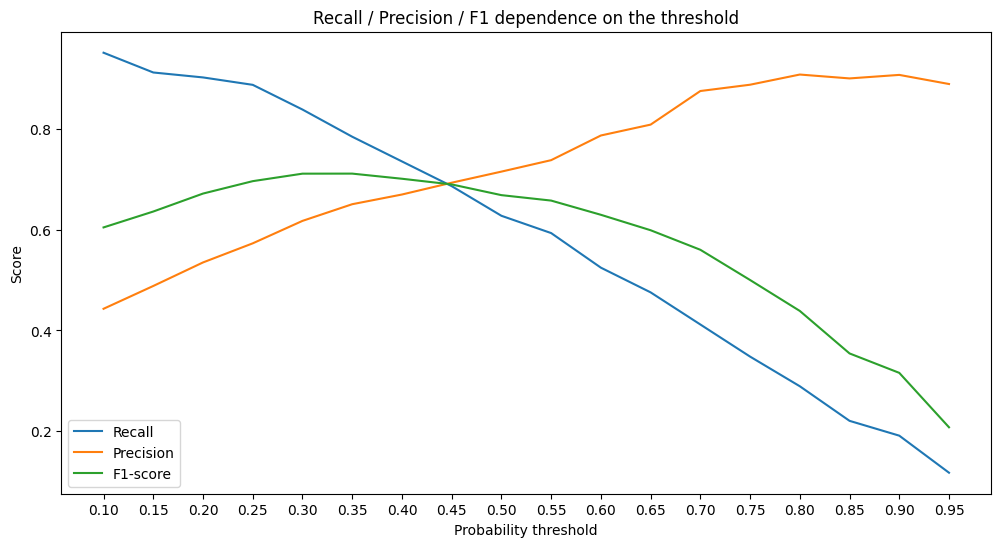

In [31]:
# нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = lr_poly.predict_proba(X_test_scaled_poly)[:, 1]

# для удобства завернём numpy-массив в Pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)

# создаём списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []

# генерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# в цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    # клиентов, для которых вероятность ухода > threshold, относим к классу 1
    # в противном случае — к классу 0
    y_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    
    # считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_pred))
    precision_scores.append(metrics.precision_score(y_test, y_pred))
    f1_scores.append(metrics.f1_score(y_test, y_pred))

# визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(12, 6)) # фигура + координатная плоскость

# строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')

# строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

# строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')

# задаём графику название и подписываем оси
ax.set(title='Recall / Precision / F1 dependence on the threshold',
    xlabel='Probability threshold',
    ylabel='Score'
)

# устанавливаем отметки по оси x
ax.set_xticks(thresholds) 

# отображаем легенду
ax.legend();

In [32]:
# находим порог вероятности, соответствующий максимальному значению F1-меры
max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]
print("Максимальное значение F1-меры: ", max_f1_threshold)

Максимальное значение F1-меры:  0.3500000000000001


In [33]:
#Задаем оптимальный порог вероятностей основываясь на максимальном значении F1
threshold_opt_f1 = 0.35

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt_f1 else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       424
           1       0.65      0.78      0.71       204

    accuracy                           0.79       628
   macro avg       0.77      0.79      0.77       628
weighted avg       0.81      0.79      0.80       628



In [34]:
#Задаем оптимальный порог вероятностей основываясь на пересечении метрик
threshold_opt_cross = 0.45

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt_cross else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       424
           1       0.69      0.69      0.69       204

    accuracy                           0.80       628
   macro avg       0.77      0.77      0.77       628
weighted avg       0.80      0.80      0.80       628



<span style="color:green">Оптимальный порог вероятности можно выбирать как по максимальному значению F1, так и по точке пересечения Precision-Recall и F1. Оба подхода имеют свои преимущества и недостатки, и выбор зависит от конкретной задачи и ее требований к метрикам.

<span style="color:green">Если выбирать порог по максимальному значению F1, то это означает, что мы стремимся найти баланс между Precision и Recall, чтобы получить наилучшее сочетание точности и полноты. Однако, если Precision и Recall имеют разный вес в конкретной задаче, то выбор порога по максимальному значению F1 может быть неоптимальным.

<span style="color:green">Если выбирать порог по точке пересечения Precision-Recall и F1, то это означает, что мы стремимся найти порог, который максимизирует F1 и при этом обеспечивает баланс между Precision и Recall. Этот подход может быть более предпочтительным, если Precision и Recall имеют разный вес в конкретной задаче, и требуется более точное управление балансом между ними.

<span style="color:green">В нашем случае, пожалуй, более предпочтителен второй вариант. Т.к. выше precision = 0.69. Значит процент ложноположительных срабатываний будет меньше.</span>


## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [35]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [36]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [37]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.57


<span style="color:green">Такой результат может быть связан с переобучением модели на тренировочных данных. Деревья решений могут очень хорошо подстроиться под тренировочные данные, что может привести к переобучению и плохой обобщающей способности на тестовых данных. 

<span style="color:green">Другая возможная причина - недостаточное количество данных для обучения модели. Если данных мало, то модель может не смочь выявить закономерности в данных и обобщить их на новые данные.

<span style="color:green">Также, возможно, что выбранные признаки не являются достаточно информативными для предсказания целевой переменной. В этом случае, необходимо провести анализ признаков и выбрать более информативные для обучения модели. 

<span style="color:green">Наконец, возможно, что дерево решений не является подходящей моделью для данной задачи. В этом случае, необходимо рассмотреть другие модели машинного обучения, которые могут лучше справиться с задачей.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [38]:
#Создаем объект класса дерево решений
dt_cut = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth = 8, 
    min_samples_leaf = 10,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt_cut.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred_cut = dt_cut.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred_cut = dt_cut.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.57


<span style="color:green">Мы ограничили глубину дерева и минимальное количество объектов в листе. Это позволило избежать переобучения и улучшить качество модели на тестовых данных. 
Разрыв между метриками на обучающей и тестовой выборках в 0.08 может быть приемлемым, но это зависит от конкретной задачи и данных. Если разрыв слишком большой, то это может свидетельствовать о переобучении модели на обучающей выборке. В таком случае, можно попробовать уменьшить глубину дерева, увеличить минимальное количество объектов в листе или использовать другие методы регуляризации, чтобы улучшить обобщающую способность модели. 
В нашем случае переобучения нет. Модель можно применять

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [39]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    max_depth=8,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.74
Test: 0.66


<span style="color:green">Наша модель улучшена. Причины:

<span style="color:green">Случайный лес - это ансамблевый метод машинного обучения, который объединяет несколько деревьев решений для улучшения качества предсказаний. Он может улучшить модель по нескольким причинам:

<span style="color:green">1. Уменьшение переобучения: случайный лес использует бутстрэп-выборки и случайный выбор признаков для каждого дерева, что позволяет уменьшить переобучение и улучшить обобщающую способность модели.

<span style="color:green">2. Улучшение точности: случайный лес объединяет предсказания нескольких деревьев, что позволяет уменьшить ошибку предсказания и улучшить точность модели.

<span style="color:green">3. Устойчивость к выбросам: случайный лес устойчив к выбросам, так как он использует несколько деревьев, каждое из которых может быть чувствительно к выбросам, но в целом, ансамбль будет более устойчивым.

<span style="color:green">4. Универсальность: случайный лес может использоваться для решения различных задач машинного обучения, таких как классификация и регрессия, и может работать с различными типами данных.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

/home/tatiana/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tatiana/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


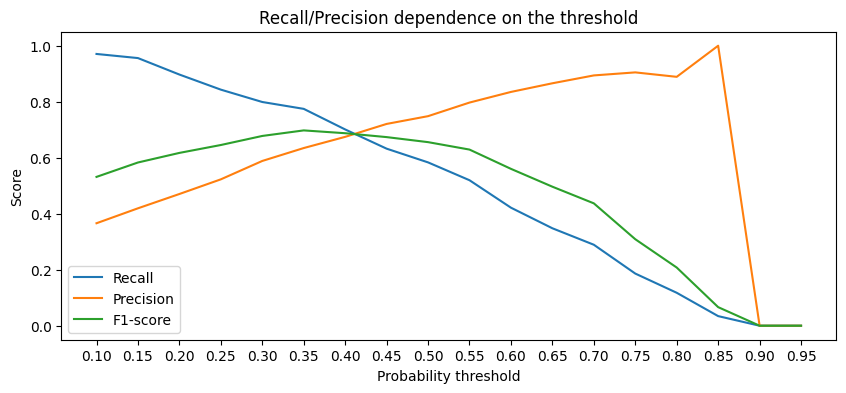

In [40]:
#Нас интересует только вероятность класса (второй столбец)
y_test_proba_pred = rf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.set_xticks(thresholds)
ax.legend();

In [41]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.35
#Людей, вероятность ухода которых высока относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       424
           1       0.63      0.77      0.70       204

    accuracy                           0.78       628
   macro avg       0.76      0.78      0.76       628
weighted avg       0.80      0.78      0.79       628



<span style="color:green">На пересечении метрик 0.4 результат немного хуже, чем при максимальном F1. Поэтому выбран threshold_opt = 0.35, Т.к при этом показателе результат модели лучший. 

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [42]:
data = {
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}

In [43]:
# конвертируем в Dataframe,
new_client = pd.DataFrame(data)

In [44]:
# Преобразование строковых данных в числовые
new_client['Gender'] = new_client['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [45]:
# Добавление новых признаков
new_client['BalanceSalaryRatio'] = new_client['Balance'] / new_client['EstimatedSalary']
new_client['TenureByAge'] = new_client['Tenure'] / new_client['Age']
new_client['CreditScoreGivenAge'] = new_client['CreditScore'] / new_client['Age']

In [46]:
# сравниваем типы данных
#new_client.info()

In [47]:
#churn_data.info()

In [48]:
new_client['CreditScore'] = new_client['CreditScore'].astype(int)
new_client['Age'] =new_client['Age'].astype(int)
new_client['Tenure'] =new_client['Tenure'].astype(int)
new_client['NumOfProducts'] =new_client['NumOfProducts'].astype(int)
new_client['HasCrCard'] =new_client['HasCrCard'].astype(int)
new_client['IsActiveMember'] =new_client['IsActiveMember'].astype(int)

In [49]:
new_client

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
0,601,1,42,1,98495.72,1,1,0,40014.76,2.461485,0.02381,14.309524


In [50]:
## предсказание на основе модели RandomForestClassifier
# делаем предсказание вероятностей
y_new_client_rf = rf.predict_proba(new_client)[:, 1]

# выводим предсказанные вероятности
print(f'Predicted probabilities: {np.round(y_new_client_rf, 2)}')

# делаем предсказание класса
y_new_client_predict_rf_clf = rf.predict(new_client)

# выводим предсказанный класс
print(f'Predicted class: {y_new_client_predict_rf_clf}')

Predicted probabilities: [0.61]
Predicted class: [1]


In [51]:

## предсказание на основе модели логистической регрессии с SGD
# производим нормализацию тренировочной выборки
new_client_scaled = scaler.transform(new_client)

# генерируем полиномиальные признаки для тренировочной выборки
new_client_scaled_poly = poly.transform(new_client_scaled)

# делаем предсказание вероятностей
y_new_client_proba_predict_lr_poly = lr_poly.predict_proba(new_client_scaled_poly)[:, 1]

# выводим предсказанные вероятности
print(f'Predicted probabilities: {np.round(y_new_client_proba_predict_lr_poly, 2)}')

# делаем предсказание класса
y_new_client_pred_lr_poly = lr_poly.predict(new_client_scaled_poly)

# выводим предсказанный класс
print(f'Predicted class: {y_new_client_pred_lr_poly}')


Predicted probabilities: [0.66]
Predicted class: [1]


<span style="color:green">Вероятность ухода клиента, которую мы получили на основании модели случайного леса, ниже, чем у модели логистической регрессии. 
Причины: Логистическая регрессия со стохастическим градиентным спуском - больше подходит для наших данных. Кроме того, стохастический градиентный спуск может помочь улучшить точность модели, поскольку он позволяет быстрее обучаться на больших объемах данных.

In [52]:
# зафиксируем версию пакетов, для воспроизводимы воспроизводимости экспериментов:
!pip freeze > requirements.txt